## Topic Modelling for 400 news articles from India - March to April 2019

In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import ast

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt


# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['say', 'says', 'from', 'subject', 're', 'edu', 'use', 'also', 'would', 'district', 'hospital', 'police', 'arrest', 'station', 'indonesia', 'indonesian'])
# stop_words.extend(['Papua', 'papua', 'Jokowi', 'Prabowo', 'Jakarta', 'Widodo', 'jakarta', 'jokowi', 'prabowo', 'widodo', 'subianto', 'year'])
# stop_words.extend(['election', 'people', 'presidential', 'papuan', 'year', 'april', 'festival', 'president'])
# stop_words.extend(['country', 'state', 'antara', 'photo'])
#stop_words.extend(['thai', 'thailand', 'breaking', 'news', 'national', 'bangkok', 'yesterday', 'year'])
csvfile = open('sample_input.csv', 'r')
df1 = pd.read_csv(csvfile)

articles_all = []
for index, row in df1.iterrows():
    text = row['text']
    articles_all.append(text)

#TODO: Remove any URLS?
data = articles_all

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

for i in texts:
    for j in i:
        if j == 'say':
            i.remove(j)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])

# Human readable format of corpus (term-frequency)
l = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
#print(l)

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.026*"cpi" + 0.023*"open" + 0.019*"office" + 0.019*"bjp" + '
  '0.019*"kamalpur" + 0.019*"jitendra" + 0.015*"attack" + 0.015*"chaudhury" + '
  '0.015*"clash" + 0.012*"administration"'),
 (1,
  '0.037*"congress" + 0.019*"bhawan" + 0.019*"bhubaneswar" + 0.019*"odisha" + '
  '0.013*"ticket" + 0.013*"today" + 0.013*"capital" + 0.013*"mohammad" + '
  '0.013*"arrest" + 0.008*"protest"'),
 (2,
  '0.020*"group" + 0.020*"house" + 0.016*"person" + 0.016*"afiz" + '
  '0.016*"rizul" + 0.012*"incident" + 0.012*"march" + 0.012*"family" + '
  '0.012*"village" + 0.012*"set"'),
 (3,
  '0.041*"student" + 0.030*"school" + 0.024*"staff" + 0.024*"protest" + '
  '0.024*"teaching" + 0.019*"gandoh" + 0.019*"shortage" + 0.019*"education" + '
  '0.013*"due" + 0.013*"demand"')]

Perplexity:  -5.839059734469338

Coherence Score:  0.7070388548923625


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.138261 -0.053434       1        1  35.335426
2     -0.001904  0.130187       2        1  32.964764
3      0.088586 -0.085959       3        1  16.578337
1      0.051579  0.009206       4        1  15.121478, topic_info=     Category      Freq             Term     Total  loglift  logprob
term                                                                
230   Default  4.000000          student  4.000000  30.0000  30.0000
294   Default  3.000000         congress  3.000000  29.0000  29.0000
223   Default  3.000000           school  3.000000  28.0000  28.0000
228   Default  2.000000            staff  2.000000  27.0000  27.0000
235   Default  2.000000         teaching  2.000000  26.0000  26.0000
148   Default  5.000000              cpi  5.000000  25.0000  25.0000
216   Default  3.000000          protest  3.000000  24.0000  24.0000
177   Default  4.000000             open  4.000000  23.0000  23.0000
288   Default  2.000000           bhawan  2.000000  22.0000  22.0000
289   Default  2.000000      bhubaneswar  2.000000  21.0000  21.0000
47    Default  3.000000           odisha  3.000000  20.0000  20.0000
207   Default  2.000000           gandoh  2.000000  19.0000  19.0000
225   Default  2.000000         shortage  2.000000  18.0000  18.0000
204   Default  2.000000        education  2.000000  17.0000  17.0000
31    Default  4.000000            house  4.000000  16.0000  16.0000
141   Default  4.000000              bjp  4.000000  15.0000  15.0000
165   Default  4.000000         kamalpur  4.000000  14.0000  14.0000
164   Default  4.000000         jitendra  4.000000  13.0000  13.0000
327   Default  1.000000           ticket  1.000000  12.0000  12.0000
291   Default  1.000000          capital  1.000000  11.0000  11.0000
313   Default  1.000000         mohammad  1.000000  10.0000  10.0000
87    Default  3.000000             afiz  3.000000   9.0000   9.0000
124   Default  3.000000            rizul  3.000000   8.0000   8.0000
5     Default  2.000000           arrest  2.000000   7.0000   7.0000
208   Default  1.000000       government  1.000000   6.0000   6.0000
202   Default  1.000000             doda  1.000000   5.0000   5.0000
199   Default  1.000000       department  1.000000   4.0000   4.0000
191   Default  1.000000         adequate  1.000000   3.0000   3.0000
203   Default  3.000000              due  3.000000   2.0000   2.0000
98    Default  2.000000           demand  2.000000   1.0000   1.0000
...       ...       ...              ...       ...      ...      ...
287    Topic4  0.621828         assembly  1.099418   1.3192  -4.8941
300    Topic4  0.621825             file  1.099425   1.3192  -4.8941
286    Topic4  0.621789         aspirant  1.099437   1.3191  -4.8942
292    Topic4  0.621778  commissionerate  1.099442   1.3191  -4.8942
305    Topic4  0.621757        impending  1.099442   1.3190  -4.8942
303    Topic4  0.621726          hadaqat  1.099464   1.3190  -4.8943
315    Topic4  0.621721             poll  1.099459   1.3190  -4.8943
306    Topic4  0.621718       individual  1.099459   1.3190  -4.8943
330    Topic4  0.621711        vandalism  1.099467   1.3189  -4.8943
318    Topic4  0.621710           rahman  1.099468   1.3189  -4.8943
301    Topic4  0.621706          forward  1.099465   1.3189  -4.8943
319    Topic4  0.621684           ranjan  1.099473   1.3189  -4.8944
329    Topic4  0.621662        vandalise  1.099486   1.3189  -4.8944
326    Topic4  0.621605            tafiq  1.099502   1.3187  -4.8945
331    Topic4  0.621600            video  1.099503   1.3187  -4.8945
307    Topic4  0.621599             khan  1.099508   1.3187  -4.8945
297    Topic4  0.621596           damage  1.099505   1.3187  -4.8945
47     Topic4  1.615737           odisha  3.465036   1.1261  -3.9393
5      Topic4  1.118267           arrest  2.282407   1.1756  -4.3073
77     Topic4  1.119160            today  4.2

### Using a mallet model.

In [5]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('\nCoherence Score: ', coherence_ldamallet)

/Users/akshayakp/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)


[(0,
  [('congress', 0.05172413793103448),
   ('house', 0.04310344827586207),
   ('rizul', 0.034482758620689655),
   ('afiz', 0.034482758620689655),
   ('mob', 0.02586206896551724),
   ('report', 0.02586206896551724),
   ('death', 0.02586206896551724),
   ('bhawan', 0.02586206896551724),
   ('family', 0.02586206896551724),
   ('accuse', 0.02586206896551724)]),
 (1,
  [('cpi', 0.046052631578947366),
   ('march', 0.039473684210526314),
   ('office', 0.039473684210526314),
   ('open', 0.039473684210526314),
   ('bjp', 0.03289473684210526),
   ('jitendra', 0.03289473684210526),
   ('kamalpur', 0.03289473684210526),
   ('attack', 0.02631578947368421),
   ('chaudhury', 0.02631578947368421),
   ('spot', 0.02631578947368421)]),
 (2,
  [('student', 0.058333333333333334),
   ('school', 0.041666666666666664),
   ('protest', 0.041666666666666664),
   ('due', 0.03333333333333333),
   ('teaching', 0.03333333333333333),
   ('reach', 0.03333333333333333),
   ('staff', 0.03333333333333333),
   ('shorta

/Users/akshayakp/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)



Coherence Score:  0.6526016721316937


In [6]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [7]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=5, step=1)

/Users/akshayakp/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)
/Users/akshayakp/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)
/Users/akshayakp/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)
/Users/akshayakp/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, var

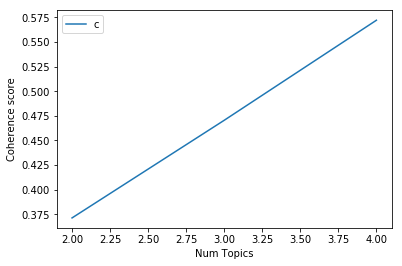

In [8]:
# Show graph
limit=5; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [9]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3714
Num Topics = 3  has Coherence Value of 0.4705
Num Topics = 4  has Coherence Value of 0.5721


In [10]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(model_topics)
# pprint(optimal_model.print_topics(num_words=10))

[(0,
  [('house', 0.043859649122807015),
   ('afiz', 0.03508771929824561),
   ('family', 0.02631578947368421),
   ('accuse', 0.02631578947368421),
   ('set', 0.02631578947368421),
   ('mob', 0.02631578947368421),
   ('death', 0.02631578947368421),
   ('area', 0.02631578947368421),
   ('ali', 0.017543859649122806),
   ('dispute', 0.017543859649122806)]),
 (1,
  [('group', 0.061068702290076333),
   ('congress', 0.04580152671755725),
   ('incident', 0.04580152671755725),
   ('clash', 0.04580152671755725),
   ('person', 0.04580152671755725),
   ('odisha', 0.03816793893129771),
   ('village', 0.03816793893129771),
   ('bhubaneswar', 0.022900763358778626),
   ('report', 0.022900763358778626),
   ('bhawan', 0.022900763358778626)]),
 (2,
  [('cpi', 0.046357615894039736),
   ('open', 0.039735099337748346),
   ('office', 0.039735099337748346),
   ('jitendra', 0.033112582781456956),
   ('kamalpur', 0.033112582781456956),
   ('march', 0.033112582781456956),
   ('bjp', 0.033112582781456956),
   ('c

In [11]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(40)


/Users/akshayakp/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)
/Users/akshayakp/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3957,"group, congress, incident, clash, person, odis...","Odisha Sun Times Bureau Brahmapur, Mar 23 Poli..."
1,1,0.0,0.4158,"house, afiz, family, accuse, set, mob, death, ...","ABHIJIT TALUKDAR Tamulpur, March 23, 2019 Tens..."
2,2,2.0,0.6553,"cpi, open, office, jitendra, kamalpur, march, ...",Tripura News 10 CPI M supporters injured after...
3,3,3.0,0.6197,"student, today, protest, school, due, teaching...","Excelsior Correspondent DODA, Mar 23 The stude..."
4,4,1.0,0.3338,"group, congress, incident, clash, person, odis...",Jeypore The Koraput district administration to...
5,5,1.0,0.3906,"group, congress, incident, clash, person, odis...",Bhubaneswar The Commissionerate Police arreste...


In [12]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4158,"house, afiz, family, accuse, set, mob, death, ...","ABHIJIT TALUKDAR Tamulpur, March 23, 2019 Tens..."
1,1.0,0.3957,"group, congress, incident, clash, person, odis...","Odisha Sun Times Bureau Brahmapur, Mar 23 Poli..."
2,2.0,0.6553,"cpi, open, office, jitendra, kamalpur, march, ...",Tripura News 10 CPI M supporters injured after...
3,3.0,0.6197,"student, today, protest, school, due, teaching...","Excelsior Correspondent DODA, Mar 23 The stude..."


In [13]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

contents = pd.Series(texts)
df_dominant_topics = pd.concat([df_dominant_topics, contents], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents', 'Text']


# Show
df_dominant_topics.to_csv('output/topic_modelling.csv')

pd.set_option('display.max_rows', 500)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,Text
0,1.0,"group, congress, incident, clash, person, odis...",1.0,0.1667,"[odisha, sun, time, bureau, brahmapur, mar, to..."
1,0.0,"house, afiz, family, accuse, set, mob, death, ...",3.0,0.5000,"[abhijit, talukdar, march, tension, grip, kamr..."
2,2.0,"cpi, open, office, jitendra, kamalpur, march, ...",1.0,0.1667,"[tripura, news, cpi, supporter, injure, jiten,..."
3,3.0,"student, today, protest, school, due, teaching...",1.0,0.1667,"[excelsior, correspondent, doda, mar, student,..."
4,1.0,"group, congress, incident, clash, person, odis...",NaN,NaN,"[jeypore, koraput, administration, today, proh..."
5,1.0,"group, congress, incident, clash, person, odis...",NaN,NaN,"[bhubaneswar, commissionerate, arrest, person,..."


In [14]:
grouped = df_dominant_topics.groupby('Dominant_Topic')
df0 = grouped.get_group(2.0)

In [15]:
df0

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,Text
2,2.0,"cpi, open, office, jitendra, kamalpur, march, ...",1.0,0.1667,"[tripura, news, cpi, supporter, injure, jiten,..."
